In [1]:
import json
import functools
from math import floor
from datetime import date, datetime, timedelta
import time
import pickle
import requests
import urllib3
from scipy.stats import linregress
import pandas as pd
from pandas import json_normalize
pd.set_option("display.max_rows", 500)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib import rcParams
rcParams['text.usetex'] = False
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)


def payload(refresh_token):
    return {
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
    'refresh_token': refresh_token,
    'grant_type': "refresh_token",
    'f': 'json'
}

def header(access_token):
    return {"Authorization": "Bearer " + access_token}

def get_athlete(CODE):
    athlete_data = requests.post(token_url, data={"client_id":CLIENT_ID, "client_secret":CLIENT_SECRET,
                                   "code":CODE, "grant_type":"authorization_code"}).json()
    return athlete_data

def athlete_dump(athlete_data):
    athlete = athlete_data.get("athlete")
    fullname = athlete.get("firstname") + athlete.get("lastname")
    with open(fullname, "wb") as f:
        pickle.dump(athlete_data, f)
        
def refresh_athlete(Athlete):
    athlete_data = Athlete.athlete_data
    if time.time() > athlete_data["expires_at"]:
        print("Token has expired, will refresh.")
        refresh_response = requests.post(token_url, data=payload(athlete_data.get("refresh_token")),
                                         verify=False).json()
        refresh = ["access_token", "expires_at", "expires_in", "refresh_token"]
        for data in refresh:
            athlete_data[data] = refresh_response.get(data)
        athlete_dump(athlete_data)
        
    else:
        print("Token still valid, expires at {}.".format(
            time.strftime("%a, %d %b %Y %H:%M:%S %Z", time.localtime(athlete_data.get("expires_at")))))
    
def open_athlete(fullname):
    with open(fullname, "rb") as f:
        athlete_data = pickle.load(f)
    return athlete_data

def get_act_data(activity_id, access_token):
    res = requests.get(activities_url+"/"+str(activity_id),
                    headers=header(access_token)).json()
    return res

def get_activities(athlete_data, page=1, per_page=200):
    athlete_id = str(athlete_data.get("athlete").get("id"))
    activities_url = athletes_url + "/" + athlete_id + "/activities"
    activities = requests.get(activities_url,
                              headers=header(athlete_data.get("access_token")),
                              params={"per_page":per_page,"page":page}).json()
    return activities

def get_all_activities(athlete_data):
    page = 1
    activities = []
    while True:
        page_activities = get_activities(athlete_data, page=page)
        if page_activities:
            activities += page_activities
            page += 1
        else:
            break
    return activities

def get_stream(activity_id, access_token, key):
    """Returns stream of key as json.
    key:'time', 'watts'
    """
    res_url = activities_url + "/" + str(activity_id) + "/streams/" + key
    res = requests.get(res_url, headers=header(access_token)).json()
    return res

#Not working yet.
def get_df(activity_id, access_token):
    """Returns Distance/Time/Watts
    Note: get_stream returns list of 2 dictionaries. E.g.,
    res is a list of 2 dictionaries: distance and time.
    """
    res = get_stream(activity_id, access_token, key="time")
    res_watts = get_stream(activity_id, access_token, key="watts")
    res_heartrate = get_stream(activity_id, access_token, key="heartrate")
    for row in res_watts:
        if row.get("type",0) == "watts":
            res.append(row)
            break
    for row in res_heartrate:
        if row.get("type",0) == "heartrate":
            res.append(row)
            break
    df = pd.DataFrame(res)
    return df

def view_sample(athlete_data, page=1, per_page=200, min=0, max=20):
    log = get_activities(athlete_data,page=page, per_page=per_page)
    view_data = ["name", "moving_time", "start_date"]
    for workout in log[min:max]:
        for data in view_data:
            print(workout.get(data))
            
def min_k(t,d):
    res = np.floor_divide(t*1000,d)
    res_min = (res/60).astype(int)
    res_sec = np.mod(res,60).astype(int)
    if res_sec < 10:
        return str(res_min) + ":0" + str(res_sec)
    else:
        return str(res_min) + ":" + str(res_sec)
    
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w

class Athlete:
    def __init__(self, name, athlete_data={},runs=[], rides=[]):
        self.name = name
        self.athlete_data = athlete_data
        self.runs = runs
        self.rides = rides
        
class Activity:
    #act_data = get_activity(activity_id, access_token)
    #act_name = act_data.get("name")
    def __init__(self, act_athlete, act_id):
        self.act_athlete = act_athlete
        self.act_id = act_id
        self.act_data = get_act_data(activity_id=act_id,
                         access_token=act_athlete.athlete_data.get("access_token"))
        self.segments = json_normalize(self.act_data.get("segment_efforts"))
        self.df = get_df(activity_id=act_id,
                         access_token=act_athlete.athlete_data.get("access_token"))
def split_by_hours(df):
    time = df.loc[0,"original_size"]
    h = time // 3600
    watts = df.loc[df.type=="watts", "data"].values[0]
    watts = [0 if w is None else w for w in watts]
    heartrate = df.loc[df.type=="heartrate", "data"].values[0]
    watts_h = []
    heartrate_h = []
    for x in range(h+1):
        sec_min = 3600*x
        sec_max = np.minimum(time, 3600*(x+1))
        watts_h.append(watts[sec_min:sec_max])
        heartrate_h.append(heartrate[sec_min:sec_max])
    return watts_h, heartrate_h
def split_by_time(df, time={"min":0, "max":3600}, shift=0):
    max_time = df.loc[0,"original_size"]
    if time.get("max") > max_time - shift:
        time["max"] = max_time - shift
    watts = df.loc[df.type=="watts", "data"].values[0]
    watts = [0 if w is None else w for w in watts]
    heartrate = df.loc[df.type=="heartrate", "data"].values[0]
    return watts[time.get("min"):time.get("max")], heartrate[time.get("min")+shift:time.get("max")+shift]


In [ ]:
# Save config as local variables. Alternatively "locals().update(config_dict)" or, better, use config_dict.
with open('../api/config.json', 'r') as f:
    config_dict = json.load(f)
    for key, val in config_dict.items():
        if type(key) == str:
            exec(key + '=val')

In [2]:
cols = ["distance", "moving_time", "average_speed", "total_elevation_gain", "id", "start_date", "average_heartrate", "type"]
def add_date(data):
    full_date = pd.to_datetime(data.start_date)
    data["date"] = full_date.dt.date

In [70]:
jan_data = json_normalize(get_all_activities(jan))

In [317]:
jan_runs = jan_data.loc[jan_data["type"]=="Run"]
jan_runs = jan_runs[cols]

In [ ]:
jan_runs["min/k"] = jan_runs.apply(lambda x: min_k(x["moving_time"],x["distance"]), axis=1)
jan_runs.head(20)

In [333]:
jan_runs.head()

,distance,moving_time,average_speed,total_elevation_gain,id,start_date,average_heartrate,type,min_k,bpm_k,pace
0,5310.8,2317,2.292,44.6,7007615147,2022-04-19T15:25:31Z,141.9,Run,7:16,1031.804060,7.271346
1,9598.5,4272,2.247,22.9,6999972730,2022-04-18T06:59:58Z,146.0,Run,7:25,1083.002552,7.417826
2,9621.8,3687,2.610,21.5,6984367056,2022-04-15T08:39:08Z,157.2,Run,6:23,1003.963915,6.386539
3,7178.4,3045,2.357,16.7,6974569075,2022-04-13T10:07:38Z,153.3,Run,7:04,1083.803494,7.069821
4,6340.3,2619,2.421,15.4,6969250198,2022-04-12T10:41:03Z,150.8,Run,6:53,1038.187467,6.884532


# Matplotlib

In [4]:
def eff_vs_pace(runs, before=date.today(), after=date.min):
    """Plot Efficiency(bpm/k) vs Pace(min/k).
    Required columns in runs: distance, moving_time, average_heartrate, date
    before, after: datetime.date,
    e.g. after=date.fromisoformat("2019-05-19").
    """
    runs = runs[(after < runs.date) & (runs.date < before)]
    pace = runs.moving_time / runs.distance *1000/60
    eff = runs.average_heartrate * pace
    fig, ax = plt.subplots()
    x = np.asarray(pace)
    y = np.asarray(eff)
    ax.set_xlabel("min/k")
    ax.set_ylabel("bpm/k")
    ax.set_title(after.isoformat() + " - " + before.isoformat()
                 + "   ({} runs)".format(len(runs)))
    return ax.scatter(x, y, s=10)

def eff_vs_elev(runs):
    """Plot Efficiency(bpm/k) vs Pace(min/k).
    Required data: distance, moving_time, average_heartrate
    """
    pace = runs.moving_time / runs.distance *1000/60
    eff = runs.average_heartrate * pace
    elev = runs.total_elevation_gain
    fig, ax = plt.subplots()
    x = np.asarray(elev)
    y = np.asarray(eff)
    ax.set_xlabel("m")
    ax.set_ylabel("bpm/k")
    ax.set_title("Efficiency vs Elevation")
    return ax.scatter(x, y)

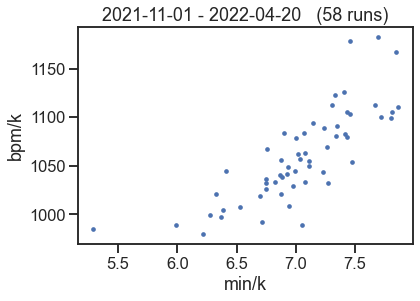

In [536]:
after = date.fromisoformat("2021-11-01")
eff_vs_pace(jan_runs.loc[jan_runs.total_elevation_gain < 50], after=after)

In [2131]:
conditions = (Simon.rides.device_watts == True) \
&(Simon.rides.has_heartrate == True)\
&(Simon.rides.suffer_score > 100)
Simon.rides.loc[conditions, :].head(100)

,resource_state,name,distance,moving_time,elapsed_time,total_elevation_gain,type,workout_type,id,start_date,...,from_accepted_tag,pr_count,total_photo_count,has_kudoed,suffer_score,athlete.id,athlete.resource_state,map.id,map.summary_polyline,map.resource_state
6,2,Morning Ride,69737.8,8860,10616,690.0,Ride,10.0,6974588158,2022-04-13T08:16:39Z,...,False,27,1,False,111.0,42345423,1,a6974588158,gz}~FkqbkAoA{XLaTbGaXFwFiAaDiBmA{Ld@}GUsDqAyCo...,2
22,2,Siena,96971.8,12545,20959,1701.0,Ride,10.0,6880814517,2022-03-25T10:26:37Z,...,False,4,2,False,197.0,42345423,1,a6880814517,cq`iG{z`dAr^wElEcJ~EyBxXnGju@qWnDqK~Mt@l[eKpFb...,2
26,2,Lunch Ride,70490.7,9249,13531,1004.0,Ride,10.0,6864530411,2022-03-22T11:23:58Z,...,False,0,2,False,116.0,42345423,1,a6864530411,en`iGi{`dA|[eEpGeLyC{q@qCoHeAcO~F_KoCuDc@gFcD]...,2
27,2,Lunch Ride,57404.0,9237,13569,1472.0,Ride,10.0,6859142689,2022-03-21T10:57:01Z,...,False,2,2,False,152.0,42345423,1,a6859142689,wr`iGgz`dAt`@}EzGmLyC_p@wCsIkAaPzFsJmCuD_@sFeD...,2
32,2,Morning Ride,95090.1,12790,16329,974.0,Ride,10.0,6807031134,2022-03-11T07:45:47Z,...,False,7,2,False,138.0,42345423,1,a6807031134,{z}~FmyckA^wMxEoSIkE}D}DaWZyH_GaDoRwAkl@vAmEaB...,2
43,2,Lunch Ride,74005.7,9973,11101,794.0,Ride,10.0,6736077005,2022-02-25T11:38:53Z,...,False,5,0,False,114.0,42345423,1,a6736077005,ow{~Fui`kA}Kj@}LuCmFqCkMiOkMmUaB_O}@qc@f@oXrEo...,2
69,2,Afternoon Ride,64203.6,8058,8776,588.0,Ride,10.0,6599913672,2022-01-29T12:55:13Z,...,False,1,0,False,140.0,42345423,1,a6599913672,qc{~F_k`kAeNi@mJjBsE_@uLoDkIgFwEiFmDoEyKaSmDwa...,2
108,2,Morning Ride,112498.0,11937,11937,1792.3,Ride,11.0,6125447611,2021-10-17T07:05:11Z,...,False,0,1,False,341.0,42345423,1,a6125447611,aoq_G_rdlAtU}B_Nti@zKbAtGcDjDqWxFyKlYiXnNoA~Kz...,2
117,2,Morning Ride,83788.7,10194,11467,1173.8,Ride,10.0,6051681412,2021-10-02T08:21:55Z,...,False,2,1,False,139.0,42345423,1,a6051681412,qpm_Gkm{mAfBsCxDjE|GPlKwC`D{CnY_KpFl@pDeGtEiCz...,2
121,2,Morning Ride,77911.7,9174,12652,1087.9,Ride,10.0,6021861897,2021-09-26T08:08:55Z,...,False,0,2,False,197.0,42345423,1,a6021861897,eim_GkyzmAcBL_DmPfCqFrDjE`Ed@~LsC|EsDvKwBxLiGb...,2


In [886]:
Siena = get_df(6880814517, Simon.athlete_data.get("access_token"))
Siena

,type,data,series_type,original_size,resolution
0,distance,"[3.6, 7.7, 11.7, 16.1, 20.6, 25.5, 30.5, 35.7,...",distance,12578,high
1,time,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",distance,12578,high
2,watts,"[147, 167, 167, 184, 218, 128, 141, 162, 148, ...",distance,12578,high
3,heartrate,"[110, 111, 113, 113, 113, 114, 114, 115, 115, ...",distance,12578,high


# plt

In [2069]:
def plot_df(Act, segment_id=None, title=None, time={"min":0, "max":3600},
            fade=True, avg=60, shift=0, pwc=150, color="Greens"):
    """ 
    act: Activity
    "min", "max": int
    avg: int,  controls rolling average of data.
    shift: int, corrects delay of heartrate in response to power.
    Return: plots watts, heartrate of act.df in timeframe "min" - "max".
    """
    df = Act.df
    if title:
        name = title
    else:
        name = Act.act_data.get("name")
    
    if segment_id:
        segment = Act.segments.loc[Act.segments.id == segment_id]
        time = {"min":segment["start_index"].values[0], "max":segment["end_index"].values[0]}
        
    fig, ax = plt.subplots(figsize=(40,40))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    watts, heartrate = split_by_time(df, time, shift=shift)
    watts_avg = moving_average(np.array(watts), avg)
    heartrate_avg = moving_average(np.array(heartrate), avg)
    length = len(watts_avg)
    watts_average = str(round(sum(watts_avg) / length,1))+"W"
    heartrate_average = str(round(sum(heartrate_avg) / length,1))+"bpm"
    
    # Scipy linear regression
    slope, intercept, rv, pv, se = linregress(watts_avg, heartrate_avg)
    rv_squared = round(rv**2,3)
    def get_pwc(y_heartrate):
        return round((y_heartrate - intercept) / slope, 2)
    if not color == "Blues":
        color_reg = "Blues"
    else:
        color_reg = "Reds"
    
    total_time = int(Act.act_data.get("moving_time"))
    time["max"] = np.minimum(time.get("max"), total_time)
    date = Act.act_data.get("start_date_local")[:10]
    moving_time = timedelta(seconds=total_time)
    distance = round(Act.act_data.get("distance")/1000)
    total_elevation_gain = str(round(Act.act_data.get("total_elevation_gain")))+"m"
    min_time = str(timedelta(seconds=int(time.get("min"))))
    max_time = str(timedelta(seconds=int(time.get("max"))))
    duration = time.get("max") - time.get("min")
    duration_iso = str(timedelta(seconds=int(duration)))
    
    if segment_id:
        segment_name = segment["name"].values[0]
        #segment_date = segment["start_date_local"].values[0][:10]
        segment_moving_time = timedelta(seconds=int(segment["moving_time"].values[0]))
        segment_distance = round(segment["distance"].values[0]/1000,3)
        segment_grade = str(segment["segment.average_grade"].values[0])+"%"
        #segment_watts = str(segment["average_watts"].values[0])+"W"
        #segment_heartrate = str(segment["average_heartrate"].values[0])+"bpm"
        segment_summary = segment_name+"\n"\
        +str(segment_moving_time)+", "+str(segment_distance)+"k, "\
        +segment_grade+"\n"+watts_average+", "+heartrate_average  
    else:
        segment_summary = "Untitled"+"\n"\
        +duration_iso+"\n"+watts_average+", "+heartrate_average 
    
    
    act_summary = name+"\n"+date+"\n"+str(moving_time)+", "+str(distance)+"k, "+total_elevation_gain
    
    if fade == False:
        ax.plot(watts, heartrate, color=plt.get_cmap(color)(0))
    else:
        for i in range(0, length, avg):
            if i+avg+1 < length:
                x = [watts_avg[j] for j in range(i,i+avg+1)]
                y = [heartrate_avg[j] for j in range(i,i+avg+1)]
                ax.plot(x, y, marker=".",
                        color=plt.get_cmap(color)(0.3 + 0.69*float(i)/(length-1)))
            
    
    plt.title(act_summary, fontsize=64, fontweight="bold",
              loc="left", pad=64, wrap=True)
    plt.title(segment_summary, {"fontsize":64,"fontweight":"bold"},
              loc="right", pad=64, wrap=True)
          
    
    legend_label = "{} - {} ({}sec)".format(min_time,max_time,duration)
    #legend_patch = mpatches.Patch(color=plt.get_cmap(color)(0.9), label=legend_label)
    legend_line = Line2D([0], [0], color=plt.get_cmap(color)(0.9), 
                         label=legend_label, linewidth=10)
    reg_label = "$r^2$: {}".format(rv_squared)
    #reg_patch = mpatches.Patch(color=plt.get_cmap(color_reg)(0.9), label=reg_label)
        
    reg_line = Line2D([0], [0], color=plt.get_cmap(color_reg)(0.9),
                                 label=reg_label, linewidth=10)
    
    avg_label = "avg: {}sec\n".format(avg)
    shift_label = "shift: {}sec\n".format(shift)
    pwc_label = "PWC{}: {}W".format(pwc, get_pwc(pwc))
    data_patch= mpatches.Patch(alpha=0, label=avg_label+"\n"+shift_label+"\n"+pwc_label)
    ax.legend(handles=[legend_line, reg_line, data_patch], 
              labelspacing=0.7, fontsize=36)
    plt.grid()
    default_xticks = [x for x in ax.get_xticks() if not x <0]
    default_yticks = ax.get_yticks()
    ax.tick_params(axis='both', which='major', pad=24)
    plt.xticks(default_xticks, [str(int(x))+"W" for x in default_xticks], 
               fontsize=36)
    plt.yticks(default_yticks, [str(int(y))+"bpm" for y in default_yticks], fontsize=36)
      
    ax.plot(np.array(default_xticks), intercept + slope*np.array(default_xticks), 
           color=plt.get_cmap(color_reg)(0.9))
    plt.show()

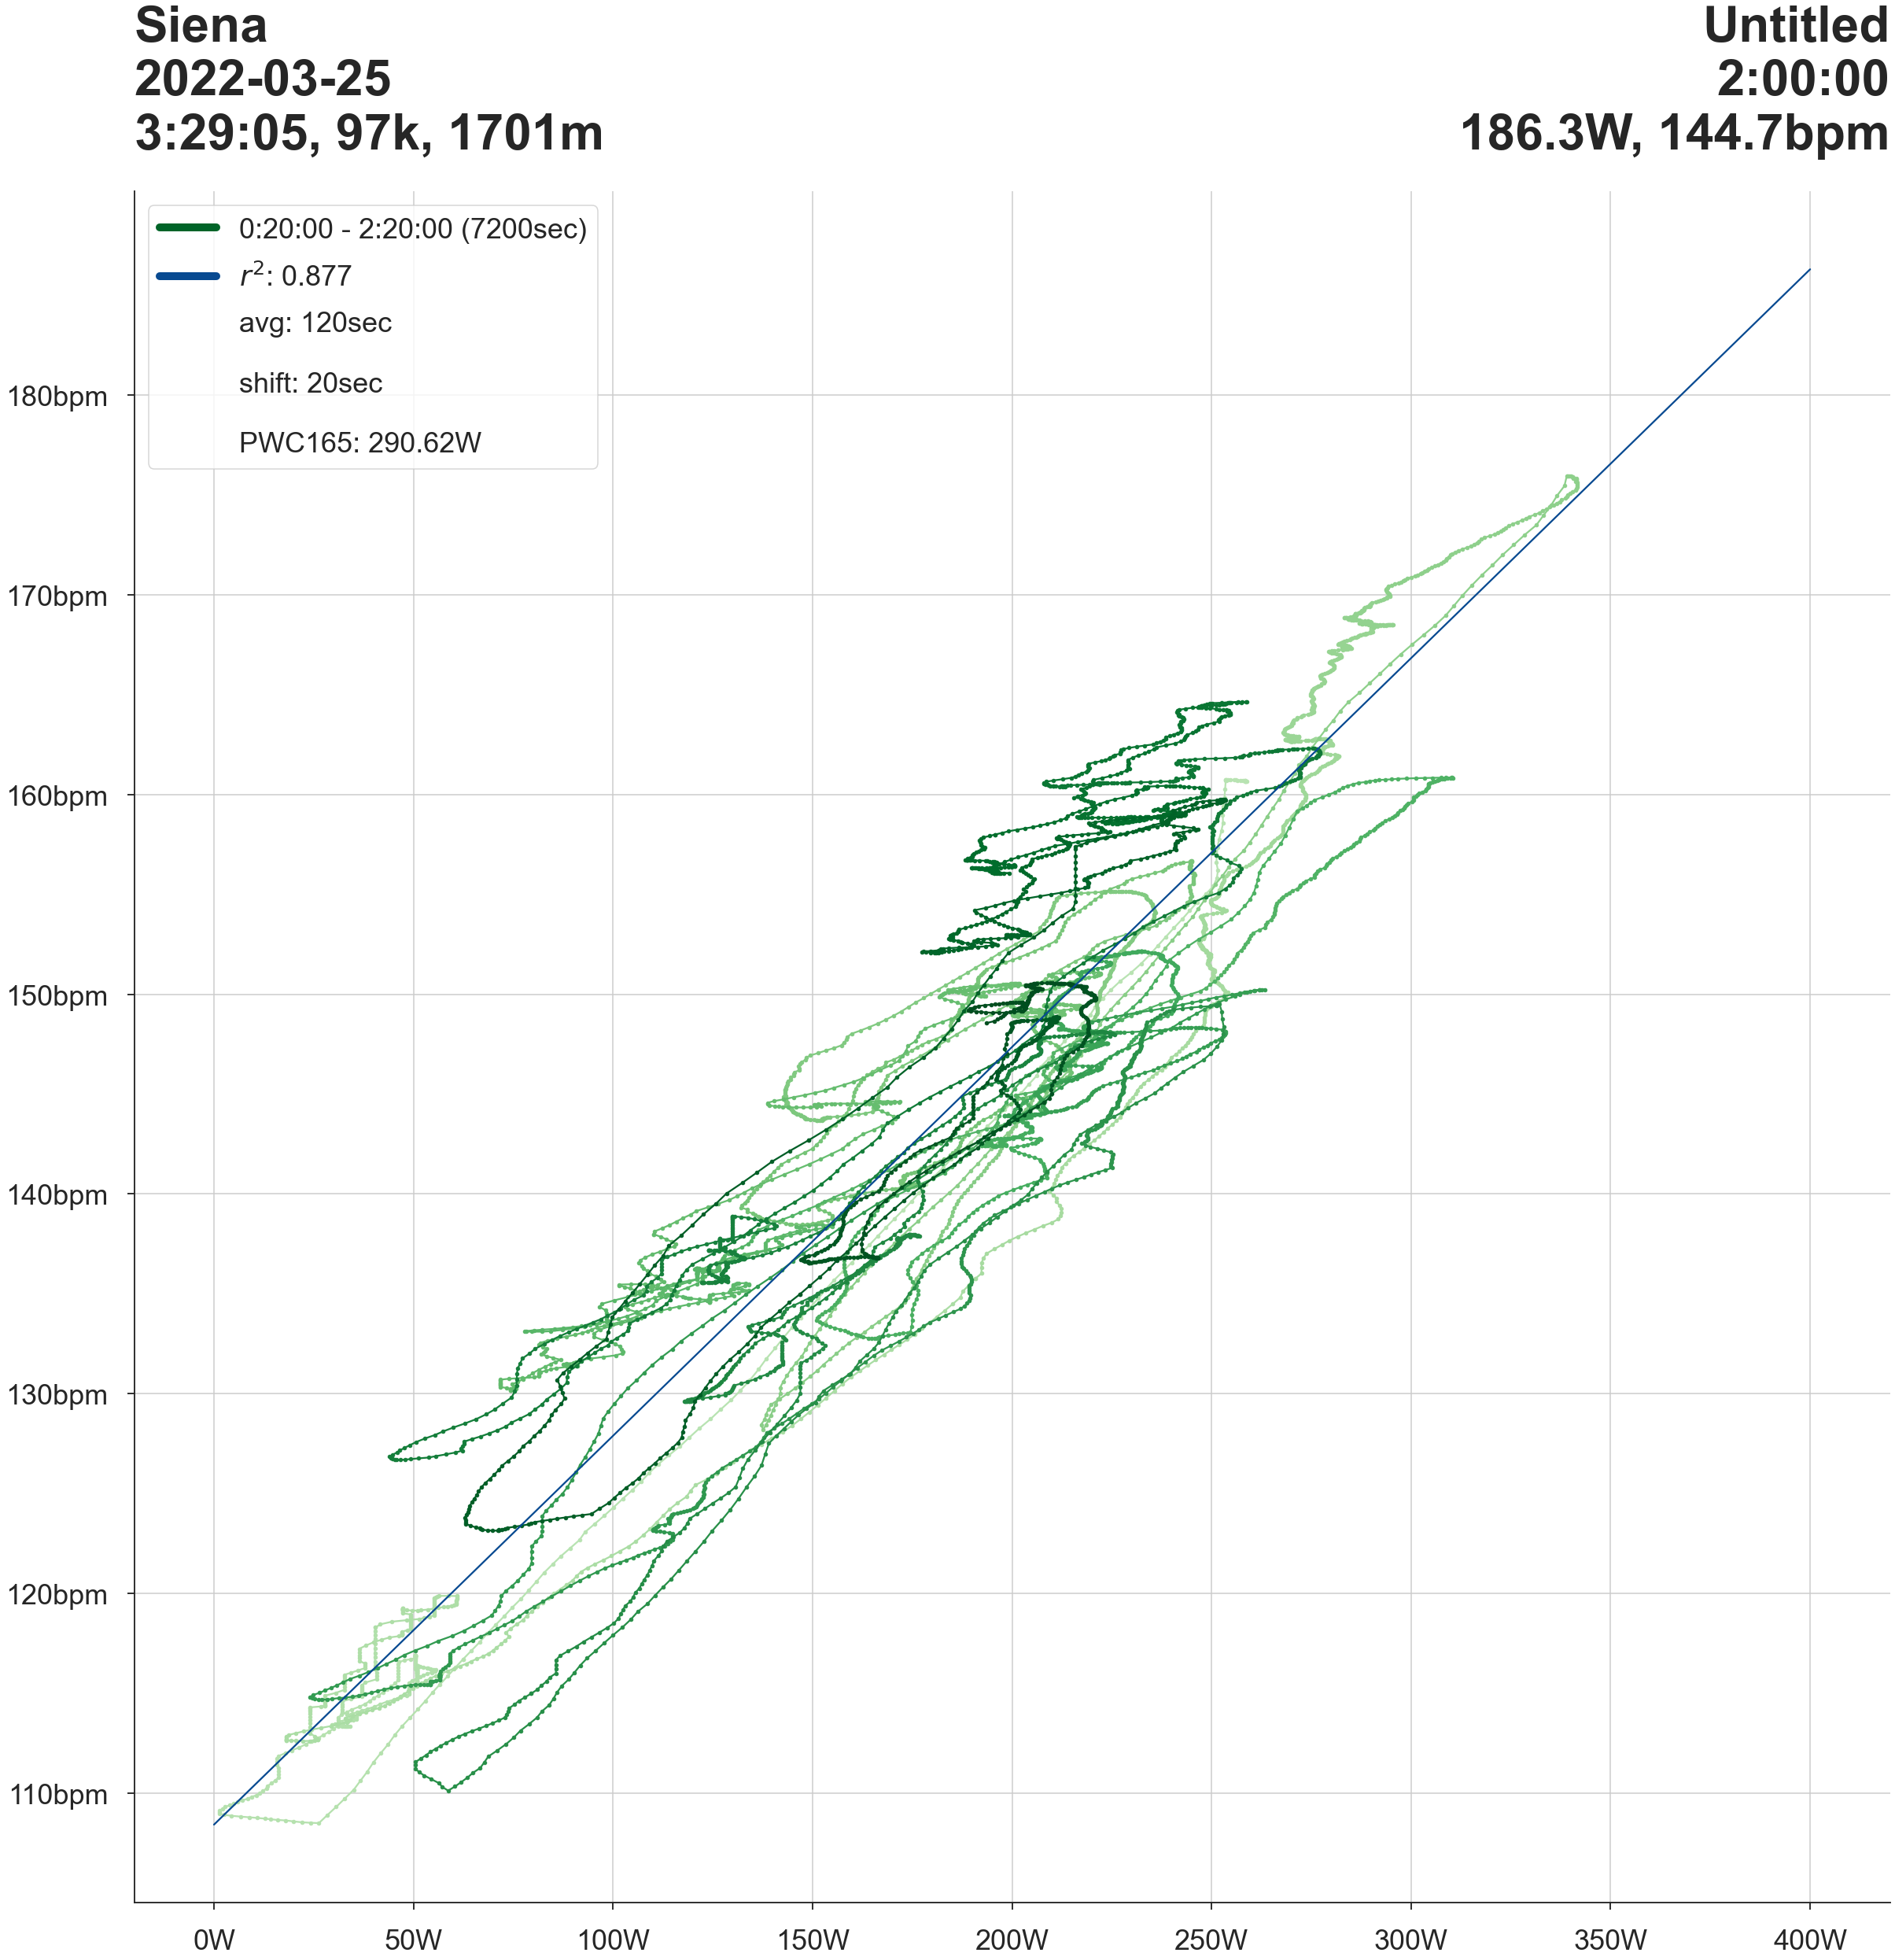

In [2157]:
# plot_df(Kaffee, pwc=165, time={"min":1200, "max":8400}, avg=120, shift=15)
plot_df(Siena, pwc=165, time={"min":1200, "max":8400}, avg=120, shift=20)

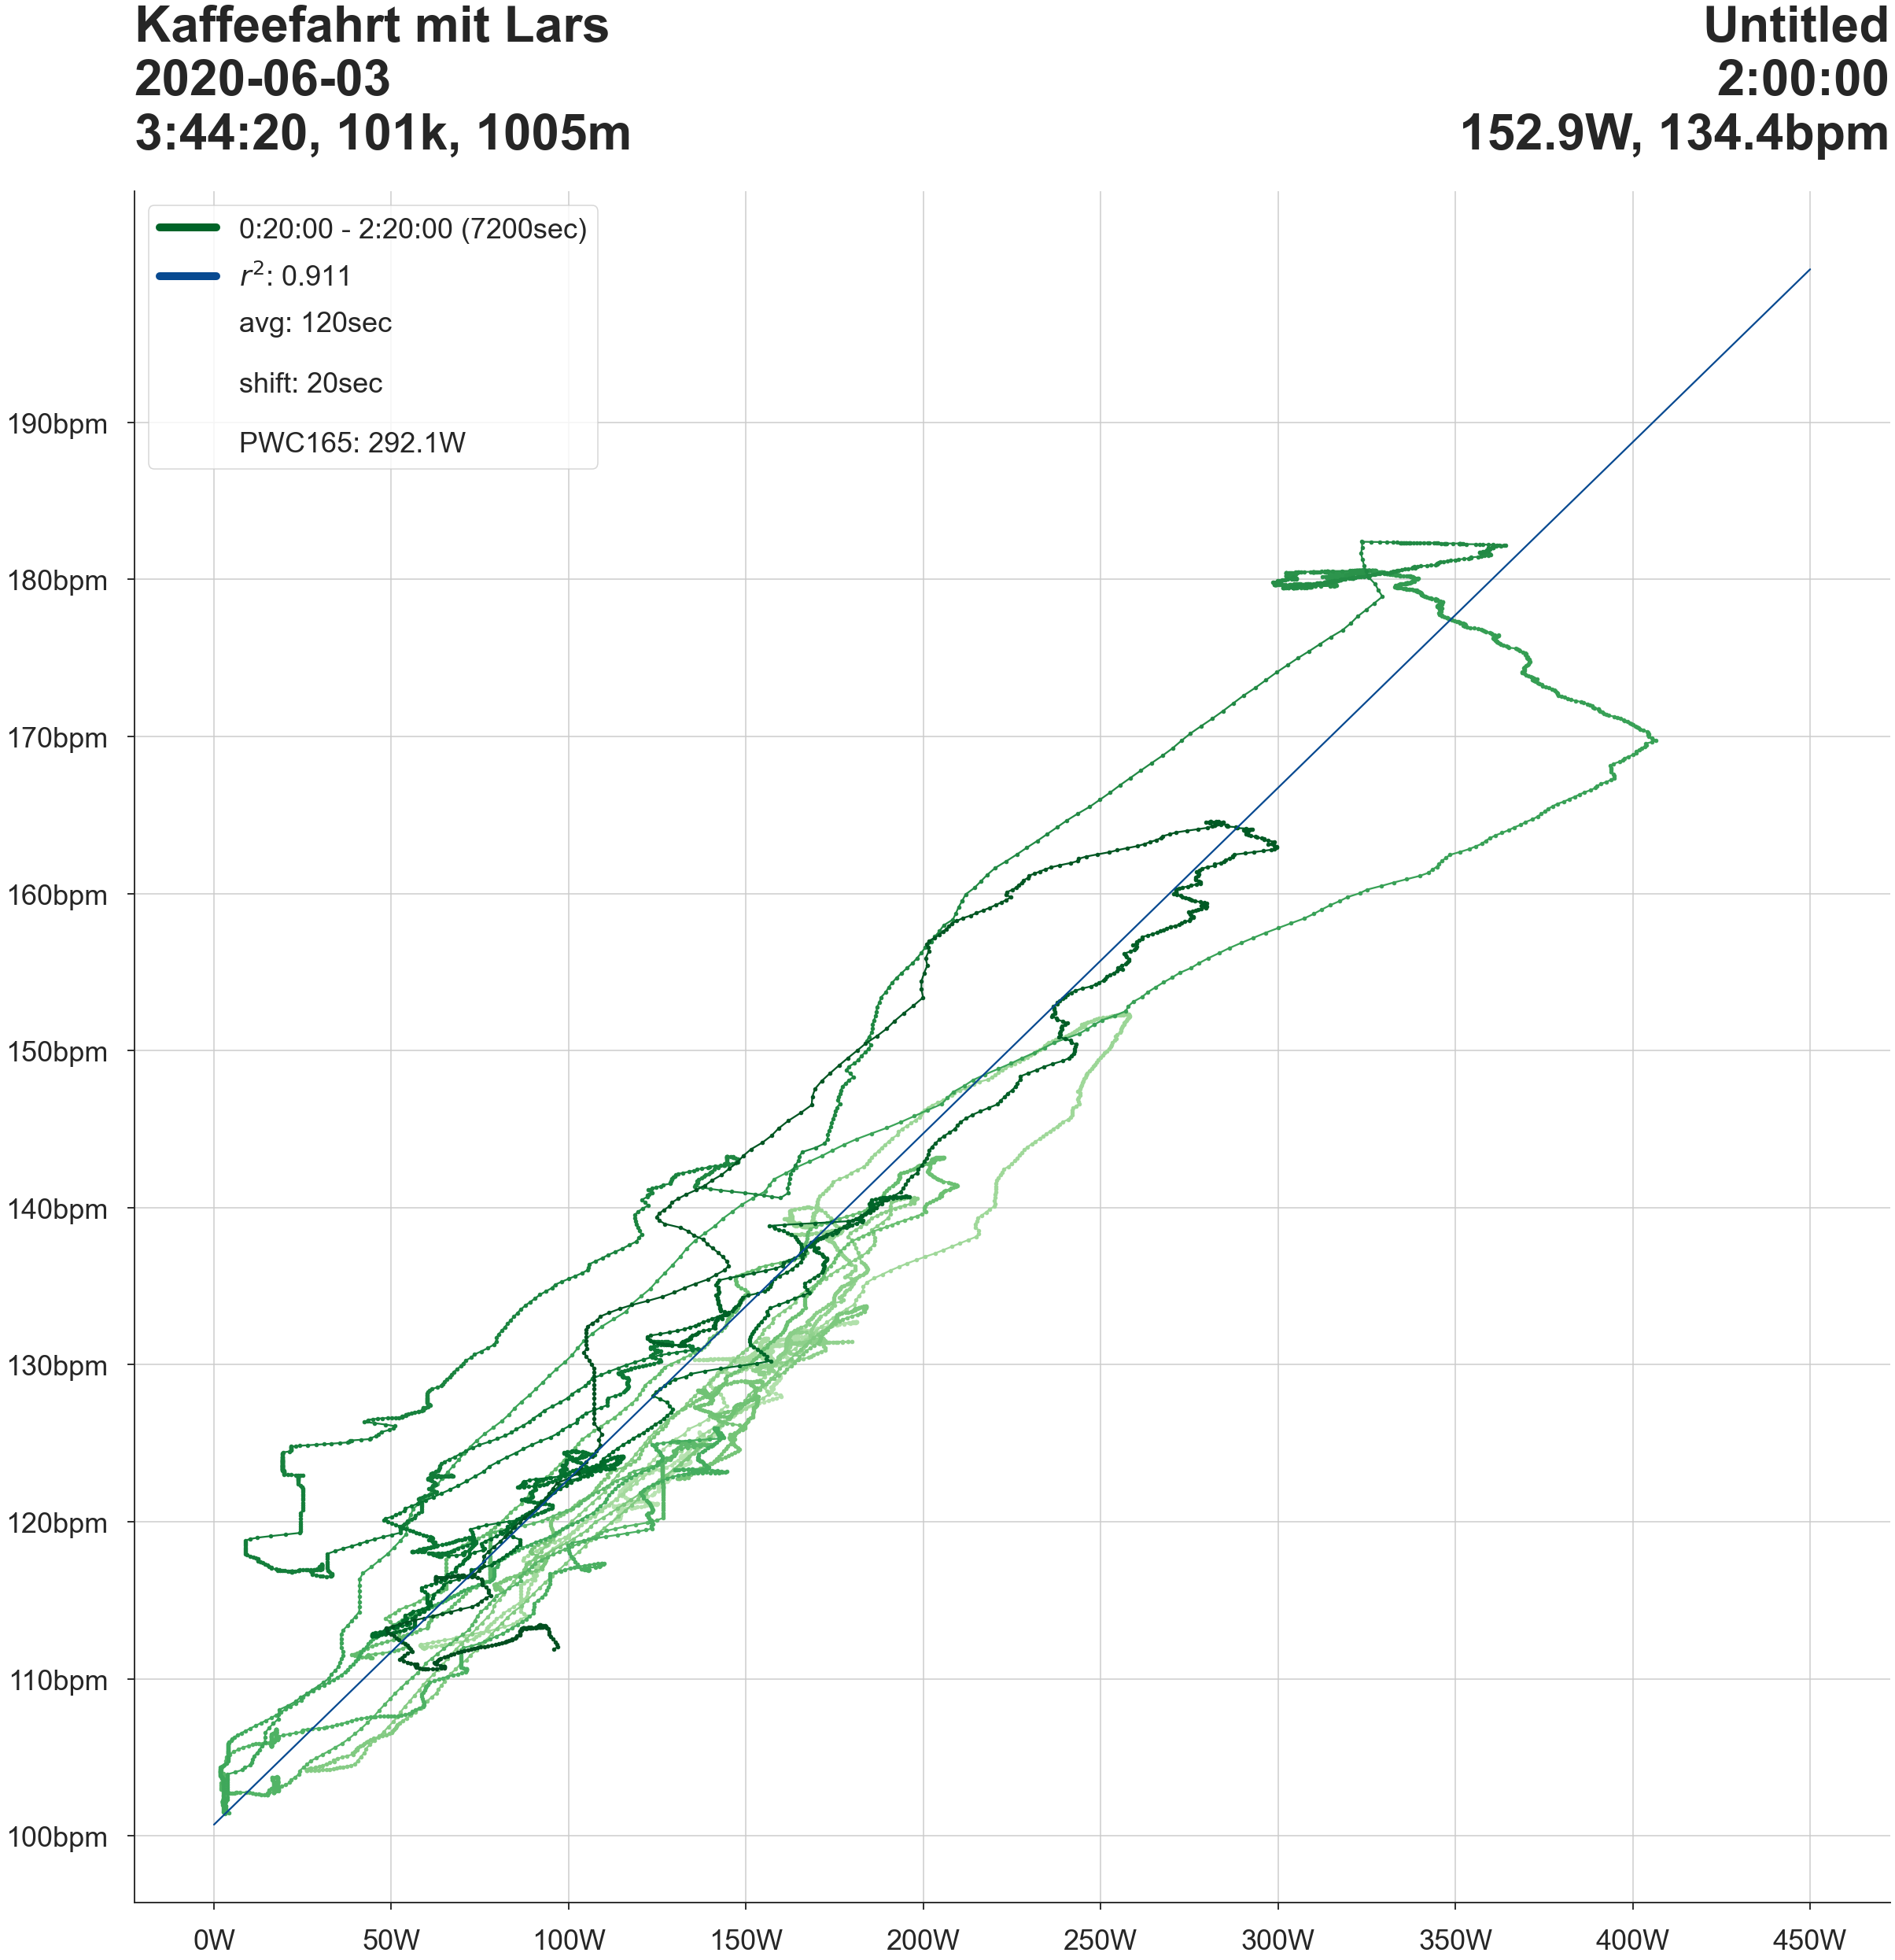

In [2156]:
plot_df(Kaffee, pwc=165, time={"min":1200, "max":8400}, avg=120, shift=20)

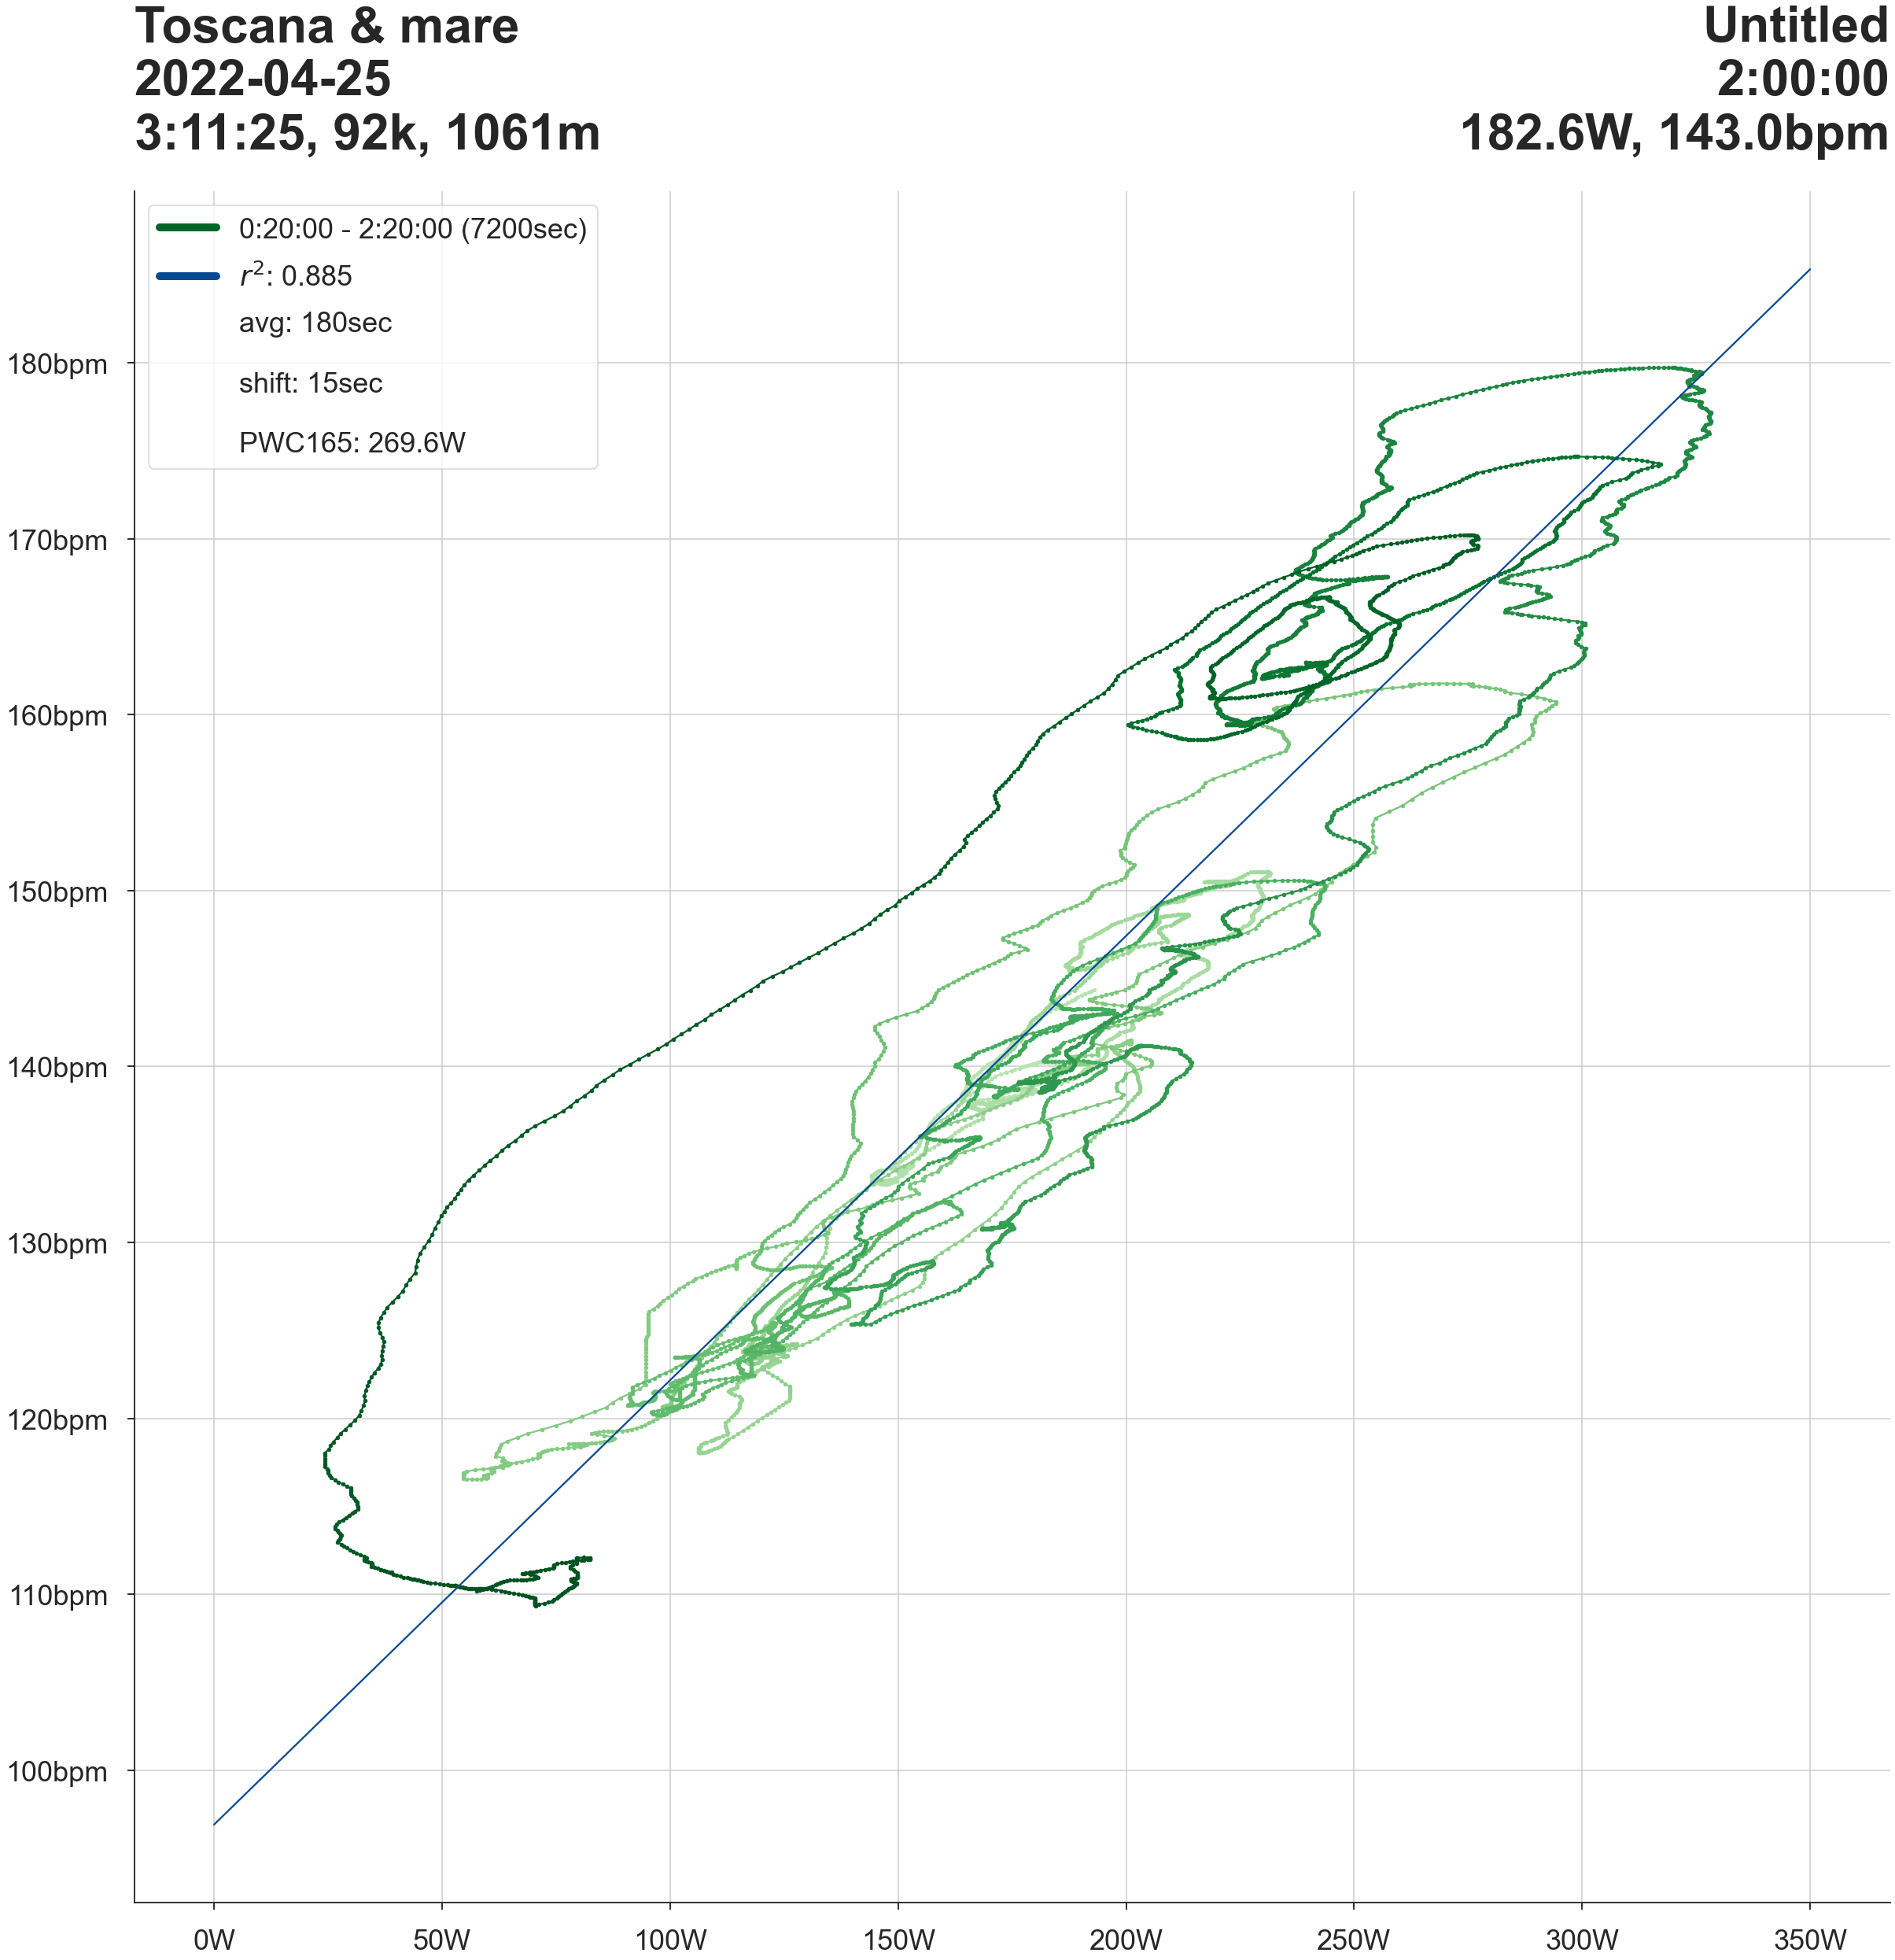

In [2179]:
plot_df(Mare, pwc=165, time={"min":1200, "max":8400}, avg=180, shift=15)